In [155]:
import matplotlib.pyplot as plt
import pickle
import os
import snap
from itertools import combinations
import numpy as np
from google.cloud import bigquery
import collections

In [7]:
## Set up bigquery environment

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/yilingc/Courses/CS224w/project/GithubNetworkAnalysis/Github224W-c6c2551f3816.json"
project_id = 'github224w'
client = bigquery.Client(project=project_id)
dataset_id = 'gh_data'
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)

In [43]:
tables = list(client.list_tables(dataset_ref))
[table.table_id for table in tables]

[u'author_commit_counts_view_2016_1',
 u'author_commit_fake_not',
 u'author_fake_not',
 u'committer_not_author',
 u'linux_project_commits',
 u'project_commit_times_since_2016_view',
 u'project_commit_times_view',
 u'python_project_commiters',
 u'python_project_more_than_100_commits',
 u'python_project_more_than_5_commiters',
 u'python_project_view',
 u'user_878937',
 u'user_commit_counts100_view_2016_1',
 u'user_commit_counts_view',
 u'user_commit_counts_view_2016_1',
 u'user_commit_project_view',
 u'watcher_counts_view_2016_1']

In [46]:
with open('../data/python_more_5_commiters.pickle', 'rb') as picklefile:
    project_authors = pickle.load(picklefile)
project_authors.head()

,project_id,author_id,committer_id
0,20471423,11534336,11534336
1,39158815,14745600,14745600
2,2256703,256,256
3,40771,256,256
4,71,256,256


In [47]:
project_authors[project_authors['author_id']==878937]['project_id'].unique()

array([53549082,  1922714, 22048477, 13844960, 30242396,  6507896,
           8460,  6431208,  9884164, 18833560, 35033856, 52822481,
           1088,  3625988,      799, 30028525, 16169652, 20037645,
         470804,  9324702, 12565778,  1345820, 28876850, 19329843,
       52624206, 29777493,   234346, 17443695, 27531903, 14191502,
       19737489,  6779299,  6391977, 29201323, 35154099, 20586681,
       29745877, 13692898, 29977074, 29355279, 10358550,    78870,
        5737292,  3296874, 13578758, 28206963, 15968339, 13527589,
       52518359, 12517135, 52582864, 27399160,  8608095, 53331184,
       43674270, 24665746, 28155698, 16357580, 22426157, 53099849,
       16777171, 56743622,  1408804,  8261633, 53320825, 28353085,
       30932629])

In [48]:
len(project_authors)

436831

In [49]:
authors = project_authors['author_id'].unique()
len(authors)

150568

In [50]:
projects = project_authors['project_id'].unique()
len(projects)

15719

In [187]:
G = snap.TNEANet.New()

In [188]:
for author in authors:
    G.AddNode(author)

In [189]:
G.GetNodes()

150568

In [54]:
for project in projects:
    p_authors = project_authors[project_authors['project_id']==project]['author_id'].unique()
    edges = combinations(p_authors, 2)
    for a, b in edges:
        G.AddEdge(a,b)

In [158]:
weights=collections.defaultdict(list)
for project in projects:
    project_commits=project_authors[project_authors['project_id']==project]
    p_authors = project_commits['author_id'].unique()
    by_author = project_commits.groupby('author_id').count()
    by_author['weight'] = np.log(by_author['project_id'])
    edges = combinations(p_authors, 2)
    for a, b in edges:
        if a > b:
            a, b = b, a
        weights[(a,b)].append(min(by_author.loc[a,'weight'],by_author.loc[b,'weight']))

In [169]:
final_weights=[(edge, sum(weights[edge])) for edge in weights]

In [185]:
G.AddFltAttrE('weight')

0

In [190]:
for edge, weight in final_weights:
    if weight > 0:
        a, b = edge
        eid = G.AddEdge(a, b)
        G.AddFltAttrDatE(eid, weight, 'weight')

In [191]:
G.GetEdges()

1708733

In [192]:
FOut = snap.TFOut("sample-weighted.graph")
G.Save(FOut)
FOut.Flush()

In [160]:
w=[sum(weights[edge]) for edge in weights]

In [170]:
final_weights.sort(cmp=lambda x, y: cmp(x[1], y[1]), reverse=True)

In [184]:
final_weights[:10]

[((4145642, 6494620), 36.09802641701576),
 ((4490298, 6494620), 33.0377556223242),
 ((63778, 2032034), 31.14063563743831),
 ((6311, 71143), 30.108741687594033),
 ((4145642, 4490298), 28.47340743085636),
 ((84761, 2032034), 27.95015928709181),
 ((2726618, 8686793), 27.914020240475935),
 ((664537, 2032034), 27.832376251435424),
 ((116088, 201383), 27.621655220119777),
 ((77283, 87488), 27.60923270012121)]

In [177]:
set([edge[0] for edge, _ in final_weights[:10]]+[edge[1] for edge, _ in final_weights[:10]])

{6311,
 63778,
 71143,
 77283,
 84761,
 87488,
 116088,
 201383,
 664537,
 2032034,
 2726618,
 4145642,
 4490298,
 6494620,
 8686793}

In [ ]:
6494620

(array([1.2234975e+07, 9.4170000e+03, 1.2010000e+03, 3.2200000e+02,
        9.0000000e+01, 3.6000000e+01, 1.4000000e+01, 1.0000000e+01,
        2.0000000e+00, 2.0000000e+00]),
 array([ 0.        ,  3.60980264,  7.21960528, 10.82940793, 14.43921057,
        18.04901321, 21.65881585, 25.26861849, 28.87842113, 32.48822378,
        36.09802642]),
 <a list of 10 Patch objects>)

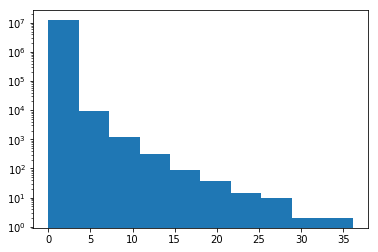

In [162]:
plt.hist(w, log=True)

In [166]:
len([i for i in w if i>0])

1708733

In [180]:
G.GetEdges()

12246069

In [62]:
FOut = snap.TFOut("unweighted.graph")
G.Save(FOut)
FOut.Flush()

In [63]:
snap.DrawGViz(G, snap.gvlDot, "unweighted.png")

In [50]:
def getDataPointsToPlot(Graph):
    outDegs = np.array([node.GetOutDeg()
                        for node in Graph.Nodes() if node.GetOutDeg() > 0])
    X = np.unique(outDegs)
    Y = [float((outDegs == i).sum())/len(outDegs) for i in X]
    return X, Y

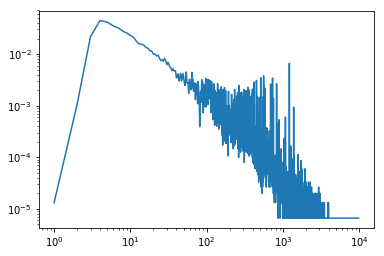

In [53]:
x, y = getDataPointsToPlot(G)
plt.loglog(x, y)

In [78]:
snap.PlotInDegDistr(G, "Author-Author", "Author-Author In Degree")

In [80]:
snap.PlotClustCf(G, "clustering", "clustering coefficient")

In [57]:
outDegs = [(node.GetOutDeg(), node.GetId()) for node in G.Nodes()]

In [58]:
outDegs.sort(reverse=True)

In [76]:
[id for deg, id in outDegs[:20]]

[6059,
 13928516,
 6311,
 71143,
 5203,
 254661,
 6543,
 11649,
 40745,
 6417,
 4901309,
 5240,
 1319258,
 219968,
 878937,
 5212,
 266472,
 71088,
 5754235,
 98431]

In [60]:
author_counts = project_authors.groupby('project_id')['author_id'].nunique()

(array([1.5477e+04, 1.6400e+02, 5.0000e+01, 1.2000e+01, 8.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   2. ,  139.9,  277.8,  415.7,  553.6,  691.5,  829.4,  967.3,
        1105.2, 1243.1, 1381. ]),
 <a list of 10 Patch objects>)

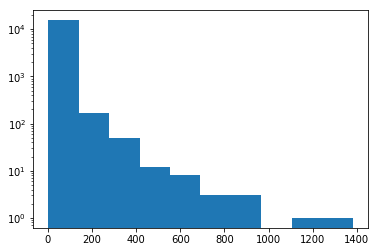

In [77]:
plt.hist(author_counts, log=True)

## Questions
If a project is forked, will the original repo's commit be counted towards the forked project?
Examined https://github.com/Jeasonxiang/Designers-Learn-Git(project-id 13552417) which is forked from https://github.com/Tower-KevinLi/Designers-Learn-Git (project-id 10836985)
13552417 only has one commit which is as expected

## Case study with linux repo
https://github.com/torvalds/linux

In [8]:
view_ref = dataset_ref.table('linux_project_commits')
view = bigquery.Table(view_ref)
view.view_query = """
#standardsql
SELECT
    author_id, committer_id, project_id, created_at
FROM
`ghtorrent-bq:ght.commits`
WHERE
project_id = 1088
"""
view = client.create_table(view)

In [ ]:
query_job = client.query("""
SELECT *
FROM
  `github224w.gh_data.linux_project_commits`
""")

results = query_job.result()
linux_commits = results.to_dataframe()

100529 commits in total

In [31]:
len(linux_commits)

100529

Covering commits from 2002-04-09 19:14:34+0000 to 2016-09-04 15:45:41+0000

In [34]:
max(linux_commits['created_at'])

Timestamp('2016-09-04 15:45:41+0000', tz='UTC')

In [12]:
len(linux_commits['author_id'].unique())

7855

In [29]:
len(linux_commits['committer_id'].unique())

655

Much more authors(the person who wrote the code, 7855) than committers(the person who commit with git, 655) - potentially only core collaborators has commit rights.

For a given user https://github.com/linusw, not all of his commits are written by him and not all of his code are committed by him.

In [16]:
sum(linux_commits['author_id']==878937)

107

In [17]:
sum(linux_commits['committer_id']==878937)

331

In [22]:
sum(linux_commits['author_id']==linux_commits['committer_id'])

28390

In [24]:
sum(linux_commits['author_id']!=linux_commits['committer_id'])

72139

In [81]:
linux_commits[linux_commits['author_id']==878937].head()

,author_id,committer_id,project_id,created_at
7586,878937,6440,1088,2013-11-18 09:37:20+00:00
8504,878937,1877051,1088,2016-04-12 07:57:35+00:00
10208,878937,8568400,1088,2016-06-08 08:29:48+00:00
21921,878937,5203,1088,2009-09-22 23:46:24+00:00
30988,878937,5209,1088,2014-01-23 13:20:01+00:00


In [98]:
a=linux_commits.groupby('author_id', as_index=False).count()

In [108]:
a['weight'] = a['project_id']/len(linux_commits)

In [110]:
a[a.author_id==878937]

,author_id,committer_id,project_id,created_at,weight
4654,878937,107,107,107,0.001064


In [120]:
commit2016q1 = linux_commits[
    ('2016-03-31 23:59:59+00:00'>linux_commits['created_at'])&
    (linux_commits['created_at']>'2016-01-01T00:00:00+00:00')
]
len(commit2016q1)

2022

In [148]:
b=commit2016q1.groupby('author_id').count()
b['weight'] = np.log(b['project_id'])
b.loc[878937]

committer_id    4.000000
project_id      4.000000
created_at      4.000000
weight          1.386294
Name: 878937, dtype: float64

In [149]:
b.loc[878937,'weight']

1.3862943611198906

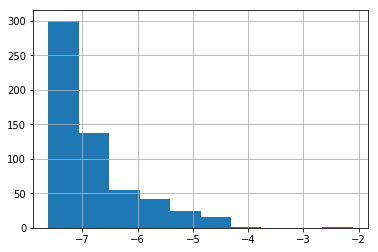

In [133]:
b['weight'].hist()

# 2016 Q1

In [246]:
query_job = client.query("""
SELECT
  *
FROM
  `github224w.gh_data.project_author_commit_2016_q1_view`
""")

results = query_job.result()
project_authors_2016_q1 = results.to_dataframe()

In [250]:
len(project_authors_2016_q1)

1081257

In [251]:
with open('./project_authors_2016_q1.pickle', 'wb') as picklefile:
    pickle.dump(project_authors_2016_q1, picklefile)

In [ ]:
with open('./project_authors_2016_q1.pickle', 'rb') as picklefile:
    project_authors = pickle.load(picklefile)

In [248]:
def construct_weighted_graph(commits):
    authors = commits['author_id'].unique()
    projects = commits['project_id'].unique()
    print('Constructing weighted graph for commits with {} authors and {} projects'.format(len(authors), len(projects)))
    G = snap.TNEANet.New()
    for author in authors:
        G.AddNode(author)
    weights = collections.defaultdict(list)
    for project in projects:
        project_commits = commits[commits['project_id']==project]
        p_authors = project_commits['author_id'].unique()
        edges = combinations(p_authors, 2)
        for a, b in edges:
            if a > b:
                a, b = b, a
            a_commits = project_commits.loc[lambda df:df.author_id==a, 'commit_times'].values[0]
            b_commits = project_commits.loc[lambda df:df.author_id==b, 'commit_times'].values[0]
            weights[(a,b)].append(np.log(min(a_commits, b_commits)))
    final_weights=[(edge, sum(weights[edge])) for edge in weights]
    G.AddFltAttrE('weight')
    for edge, weight in final_weights:
        if weight > 0:
            a, b = edge
            eid = G.AddEdge(a, b)
            G.AddFltAttrDatE(eid, weight, 'weight')
    return G, final_weights

In [ ]:
G, weights = construct_weighted_graph(project_authors_2016_q1)

In [ ]:
len(weights)

In [ ]:
weights

In [ ]:
G.GetEdges()

Approach 2, taking log of the sum

In [ ]:
def construct_weighted_graph_2(commits):
    authors = commits['author_id'].unique()
    projects = commits['project_id'].unique()
    print('Constructing weighted graph for commits with {} authors and {} projects'.format(len(authors), len(projects)))
    G = snap.TNEANet.New()
    for author in authors:
        G.AddNode(author)
    weights = collections.defaultdict(list)
    for project in projects:
        project_commits = commits[commits['project_id']==project]
        p_authors = project_commits['author_id'].unique()
        edges = combinations(p_authors, 2)
        for a, b in edges:
            if a > b:
                a, b = b, a
            a_commits = project_commits.loc[lambda df:df.author_id==a, 'commit_times'].values[0]
            b_commits = project_commits.loc[lambda df:df.author_id==b, 'commit_times'].values[0]
            weights[(a,b)].append(min(a_commits, b_commits))
    final_weights=[(edge, np.log(sum(weights[edge]))) for edge in weights]
    G.AddFltAttrE('weight')
    for edge, weight in final_weights:
        if weight > 0:
            a, b = edge
            eid = G.AddEdge(a, b)
            G.AddFltAttrDatE(eid, weight, 'weight')
    return G, final_weights

In [ ]:
G2, weights_2 = construct_weighted_graph_2(project_authors_2016_q1)

Approach 3, sum of logs + normalize with the number of author

In [ ]:
def construct_weighted_graph_3(commits):
    authors = commits['author_id'].unique()
    projects = commits['project_id'].unique()
    print('Constructing weighted graph for commits with {} authors and {} projects'.format(len(authors), len(projects)))
    G = snap.TNEANet.New()
    for author in authors:
        G.AddNode(author)
    weights = collections.defaultdict(list)
    for project in projects:
        project_commits = commits[commits['project_id']==project]
        p_authors = project_commits['author_id'].unique()
        edges = combinations(p_authors, 2)
        for a, b in edges:
            if a > b:
                a, b = b, a
            a_commits = project_commits.loc[lambda df:df.author_id==a, 'commit_times'].values[0]
            b_commits = project_commits.loc[lambda df:df.author_id==b, 'commit_times'].values[0]
            weights[(a,b)].append(np.log(min(a_commits, b_commits))/np.log(len(p_authors)))
    final_weights=[(edge, sum(weights[edge])) for edge in weights]
    G.AddFltAttrE('weight')
    for edge, weight in final_weights:
        if weight > 0:
            a, b = edge
            eid = G.AddEdge(a, b)
            G.AddFltAttrDatE(eid, weight, 'weight')
    return G, final_weights

In [ ]:
G3, weights_3 = construct_weighted_graph_3(project_authors_2016_q1)

Approach 4, log of sum normalized with the number of authors

In [ ]:
def construct_weighted_graph_4(commits):
    authors = commits['author_id'].unique()
    projects = commits['project_id'].unique()
    print('Constructing weighted graph for commits with {} authors and {} projects'.format(len(authors), len(projects)))
    G = snap.TNEANet.New()
    for author in authors:
        G.AddNode(author)
    weights = collections.defaultdict(list)
    for project in projects:
        project_commits = commits[commits['project_id']==project]
        p_authors = project_commits['author_id'].unique()
        edges = combinations(p_authors, 2)
        for a, b in edges:
            if a > b:
                a, b = b, a
            a_commits = project_commits.loc[lambda df:df.author_id==a, 'commit_times'].values[0]
            b_commits = project_commits.loc[lambda df:df.author_id==b, 'commit_times'].values[0]
            weights[(a,b)].append(min(a_commits, b_commits)/len(p_authors))
    final_weights=[(edge, np.log(sum(weights[edge]))) for edge in weights]
    G.AddFltAttrE('weight')
    for edge, weight in final_weights:
        if weight > 0:
            a, b = edge
            eid = G.AddEdge(a, b)
            G.AddFltAttrDatE(eid, weight, 'weight')
    return G, final_weights

In [ ]:
G4, weights_4 = construct_weighted_graph_4(project_authors_2016_q1)

In [268]:
with open('../data/2016_q1_data.pickle', 'rb') as picklefile:
    q1_data = pickle.load(picklefile)

In [275]:
authors = q1_data['author_id'].unique()

In [286]:
FIn = snap.TFIn("weight2.graph")
G = snap.TNEANet.Load(FIn)
for node in G.Nodes():
    if node.GetId() not in authors:
        G.DelNode(node.GetId())
FOut = snap.TFOut("weight3-adjusted.graph")
G.Save(FOut)
FOut.Flush()
G.GetNodes(), G.GetEdges()

(176061, 2977961)

In [273]:
with open('weight1.pickle', 'rb') as picklefile:
    weights = pickle.load(picklefile)

In [274]:
weights.sort(cmp=lambda x, y: cmp(x[1], y[1]), reverse=True)
weights[:10]

[((11649, 1663412), 635.5815865649815),
 ((334171, 8682787), 496.17032319222284),
 ((6417, 40745), 495.81092931339555),
 ((6417, 2829719), 441.8510299250248),
 ((5203, 71143), 431.680295908425),
 ((49284, 84761), 421.0733921930192),
 ((210169, 334171), 413.77507160645524),
 ((210169, 8682787), 413.0819244258953),
 ((26415, 49284), 412.61942625322285),
 ((49284, 761529), 401.0110959241936)]

(array([4.19813e+06, 1.40620e+04, 2.09200e+03, 2.87000e+02, 6.40000e+01,
        2.20000e+01, 8.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0.        ,  63.55815866, 127.11631731, 190.67447597,
        254.23263463, 317.79079328, 381.34895194, 444.9071106 ,
        508.46526925, 572.02342791, 635.58158656]),
 <a list of 10 Patch objects>)

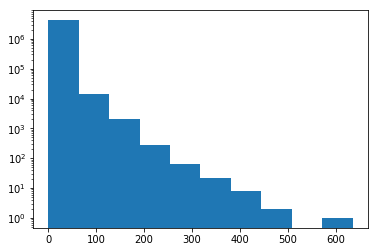

In [262]:
plt.hist([w for edge,w in weights], log=True)

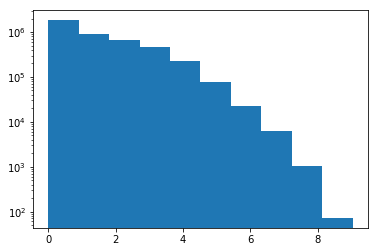

In [263]:
with open('weight2.pickle', 'rb') as picklefile:
    weights2 = pickle.load(picklefile)
    weights2.sort(cmp=lambda x, y: cmp(x[1], y[1]), reverse=True)
    weights2[:10]
    plt.hist([w for edge,w in weights2], log=True)

(array([1.834215e+06, 9.251400e+05, 6.521960e+05, 4.709850e+05,
        2.252040e+05, 7.696800e+04, 2.277500e+04, 6.080000e+03,
        1.033000e+03, 7.200000e+01]),
 array([0.        , 0.90408561, 1.80817121, 2.71225682, 3.61634243,
        4.52042803, 5.42451364, 6.32859924, 7.23268485, 8.13677046,
        9.04085606]),
 <a list of 10 Patch objects>)

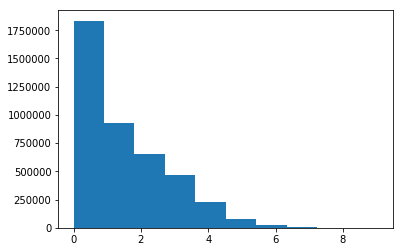

In [266]:
plt.hist([w for edge,w in weights2])

In [267]:
weights2[:10]

[((9235906, 11337077), 9.04085606398372),
 ((9235906, 11337100), 9.002331708246244),
 ((11337077, 11337100), 9.002331708246244),
 ((5291, 316297), 8.954415331137593),
 ((11337077, 11337143), 8.887376485379763),
 ((11337100, 11337143), 8.887376485379763),
 ((9235906, 11337143), 8.887376485379763),
 ((11337120, 11337143), 8.835501457409778),
 ((11337077, 11337120), 8.835501457409778),
 ((9235906, 11337120), 8.835501457409778)]

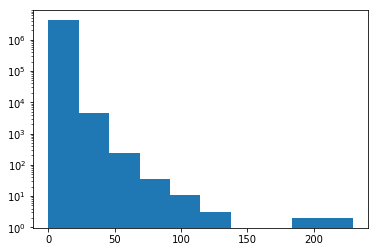

In [264]:
with open('weight3.pickle', 'rb') as picklefile:
    weights3 = pickle.load(picklefile)
    weights3.sort(cmp=lambda x, y: cmp(x[1], y[1]), reverse=True)
    weights3[:10]
    plt.hist([w for edge,w in weights3], log=True)